# Robot UR10

## Integrantes:

##### -Sebastian Quintero
##### -Nicolas Andres Morales Moreno
##### -Juan Pablo Pulido Angel
##### -Daniel Felipe Puerta

## Parametros Denavit-Hatenberg

In [1]:
import roboticstoolbox as rtb
import numpy as np
import sympy as sp
from sympy import sin, cos, Matrix
import math
import matplotlib.pyplot as plt

In [2]:

#Se define los parametros DH con la libreria roboticstoolbox.

UR10=rtb.models.DH.UR10()

print("Tabla de parametros DH")
UR10

Tabla de parametros DH


DHRobot: UR10 (by Universal Robotics), 6 joints (RRRRRR), dynamics, standard DH parameters
┌────┬────────┬─────────┬────────┐
│θⱼ  │   dⱼ   │   aⱼ    │   ⍺ⱼ   │
├────┼────────┼─────────┼────────┤
│ q1 │ 0.1273 │       0 │  90.0° │
│ q2 │      0 │  -0.612 │   0.0° │
│ q3 │      0 │ -0.5723 │   0.0° │
│ q4 │ 0.1639 │       0 │  90.0° │
│ q5 │ 0.1157 │       0 │ -90.0° │
│ q6 │ 0.0922 │       0 │   0.0° │
└────┴────────┴─────────┴────────┘

┌─┬──┐
└─┴──┘

┌─────┬───────┬─────┬─────┬─────┬──────┬─────┐
│name │ q0    │ q1  │ q2  │ q3  │ q4   │ q5  │
├─────┼───────┼─────┼─────┼─────┼──────┼─────┤
│  qr │  180° │  0° │  0° │  0° │  90° │  0° │
│  qz │  0°   │  0° │  0° │  0° │  0°  │  0° │
└─────┴───────┴─────┴─────┴─────┴──────┴─────┘

## Cinematica Directa

In [3]:

#Funcion que convierte los parametros DH a traves de la traformacion homogénea
def Tdh(d, theta, a, alpha):
    Tdh = np.array([[np.cos(theta), -np.cos(alpha)*np.sin(theta), np.sin(alpha)*np.sin(theta) , a*np.cos(theta) ],
                    [np.sin(theta), np.cos(alpha)*np.cos(theta),-np.sin(alpha)*np.cos(theta) ,a*np.sin(theta) ],
                    [0,np.sin(alpha),np.cos(alpha) ,d],
                    [0,0, 0, 1]])
    return Tdh

#Funcion que resuelve la cinematica directa
def Cinematica_directa_UR10(q, l1, l2, l3, l4, l5, l6):

    T01 = Tdh(    l1,    q[0],   0,    np.pi/2)
    T12 = Tdh(     0,    q[1],  -l2,          0)
    T23 = Tdh(     0,    q[2],  -l3,          0)
    T34 = Tdh(    l4,    q[3],    0,    np.pi/2)
    T45 = Tdh(    l5,    q[4],    0,   -np.pi/2)
    T56 = Tdh(    l6,    q[5],    0,          0)

#Se multiplican las matrices de transformacion homogénea
    Tf = T01@(T12)@(T23)@(T34)@(T45)@(T56)
#Se toma la matriz de rotacion
    M_posicion = Tf[:, -1]
    return M_posicion

In [4]:
#Prueba de la cinematica directa

l1 = 0.1273; l2 = 0.612; l3 = 0.5723; l4 = 0.1639 ; l5 = 0.1157; l6= 0.0922 
q = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
Ejemplo= Cinematica_directa_UR10(q, l1, l2, l3, l4, l5,l6)
Ejemplo

array([-1.00925673, -0.34730574, -0.37520657,  1.        ])

### Comprobación 

In [5]:
#Se usa la libreria de Robotic Toolbox con los mismos datos que se usaron en el ejemplo
S=UR10.fkine([0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
print("Cinematica directa")
print(S)

Cinematica directa
   0.0474   -0.9768   -0.2089   -1.009     
  -0.3929    0.1741   -0.903    -0.3473    
   0.9184    0.1249   -0.3755   -0.3752    
   0         0         0         1         



## Cinematica Inversa Metodo Newton

### Calculo del Jacobiano

In [6]:
#Se define una funcion donde se hara la transformacion homogenenea a traves de Sympy 

def Tdh_2(d, theta, a, alpha):
    Tdh = sp.Matrix([[sp.cos(theta), -sp.cos(alpha)*sp.sin(theta),  sp.sin(alpha)*sp.sin(theta), a*sp.cos(theta)],
                     [sp.sin(theta),  sp.cos(alpha)*sp.cos(theta), -sp.sin(alpha)*sp.cos(theta), a*sp.sin(theta)],
                     [0,        sp.sin(alpha),     sp.cos(alpha),      d],
                     [0,         0,      0,      1]])
    return Tdh
#Se realiza la cinematica directa teniendo en cuenta los parametros DH y utilizando la funcion de matriz homogenea

def cinematica_directa_UR10_2(q, l1, l2, l3, l4, l5,l6):

    T01 = Tdh_2(    l1,    q[0],   l2,   -sp.pi/2)
    T12 = Tdh_2(     0,    q[1],   l3,          0)
    T23 = Tdh_2(     0,    q[2],   l4,    sp.pi/2)
    T34 = Tdh_2(    l5,    q[3],    0,   -sp.pi/2)
    T45 = Tdh_2(     0,    q[4],    0,    sp.pi/2)
    T56 = Tdh_2(    l6,    q[5],    0,    sp.pi)

    Tf = T01@(T12)@(T23)@(T34)@(T45)@(T56)
    #Se toma la ultima columna la cual es la matriz de rotacion.
    Ma_rotacion = Tf[:, -1]
    return Ma_rotacion

In [7]:
q1, q2, q3, q4, q5, q6 = sp.symbols('q1 q2 q3 q4 q5 q6')
l1, l2, l3, l4, l5, l6= sp.symbols('l1 l2 l3 l4 l5 l6')
q = [q1,q2,q3,q4,q5,q6]
Matriz_rotacion = cinematica_directa_UR10_2(q, l1, l2, l3, l4, l5, l6)
print(Matriz_rotacion)

Matrix([[l2*cos(q1) + l3*cos(q1)*cos(q2) - l4*sin(q2)*sin(q3)*cos(q1) + l4*cos(q1)*cos(q2)*cos(q3) + l5*(sin(q2)*cos(q1)*cos(q3) + sin(q3)*cos(q1)*cos(q2)) + l6*(((-sin(q2)*sin(q3)*cos(q1) + cos(q1)*cos(q2)*cos(q3))*cos(q4) - sin(q1)*sin(q4))*sin(q5) - (-sin(q2)*cos(q1)*cos(q3) - sin(q3)*cos(q1)*cos(q2))*cos(q5))], [l2*sin(q1) + l3*sin(q1)*cos(q2) - l4*sin(q1)*sin(q2)*sin(q3) + l4*sin(q1)*cos(q2)*cos(q3) + l5*(sin(q1)*sin(q2)*cos(q3) + sin(q1)*sin(q3)*cos(q2)) + l6*(((-sin(q1)*sin(q2)*sin(q3) + sin(q1)*cos(q2)*cos(q3))*cos(q4) + sin(q4)*cos(q1))*sin(q5) - (-sin(q1)*sin(q2)*cos(q3) - sin(q1)*sin(q3)*cos(q2))*cos(q5))], [l1 - l3*sin(q2) - l4*sin(q2)*cos(q3) - l4*sin(q3)*cos(q2) + l5*(-sin(q2)*sin(q3) + cos(q2)*cos(q3)) + l6*(-(sin(q2)*sin(q3) - cos(q2)*cos(q3))*cos(q5) + (-sin(q2)*cos(q3) - sin(q3)*cos(q2))*sin(q5)*cos(q4))], [1]])


In [8]:
#Se toma la matriz de rotacion generada por la funcion de cinematica directa y se le aplica el jacobiano.
q1, q2, q3, q4, q5, q6=sp.symbols("q1 q2 q3 q4 q5 q6")
l1, l2, l3, l4, l5, l6=sp.symbols("l1 l2 l3 l4 l5 l6")

x = Matriz_rotacion[0,:]
y = Matriz_rotacion[1,:]
z = Matriz_rotacion[2,:]
X = Matrix([x,y,z])
Y = Matrix([q1, q2, q3, q4, q5])

Jacobiano = X.jacobian(Y)
Jacobiano

Matrix([
[-l2*sin(q1) - l3*sin(q1)*cos(q2) + l4*sin(q1)*sin(q2)*sin(q3) - l4*sin(q1)*cos(q2)*cos(q3) + l5*(-sin(q1)*sin(q2)*cos(q3) - sin(q1)*sin(q3)*cos(q2)) + l6*(((sin(q1)*sin(q2)*sin(q3) - sin(q1)*cos(q2)*cos(q3))*cos(q4) - sin(q4)*cos(q1))*sin(q5) - (sin(q1)*sin(q2)*cos(q3) + sin(q1)*sin(q3)*cos(q2))*cos(q5)), -l3*sin(q2)*cos(q1) - l4*sin(q2)*cos(q1)*cos(q3) - l4*sin(q3)*cos(q1)*cos(q2) + l5*(-sin(q2)*sin(q3)*cos(q1) + cos(q1)*cos(q2)*cos(q3)) + l6*(-(sin(q2)*sin(q3)*cos(q1) - cos(q1)*cos(q2)*cos(q3))*cos(q5) + (-sin(q2)*cos(q1)*cos(q3) - sin(q3)*cos(q1)*cos(q2))*sin(q5)*cos(q4)), -l4*sin(q2)*cos(q1)*cos(q3) - l4*sin(q3)*cos(q1)*cos(q2) + l5*(-sin(q2)*sin(q3)*cos(q1) + cos(q1)*cos(q2)*cos(q3)) + l6*(-(sin(q2)*sin(q3)*cos(q1) - cos(q1)*cos(q2)*cos(q3))*cos(q5) + (-sin(q2)*cos(q1)*cos(q3) - sin(q3)*cos(q1)*cos(q2))*sin(q5)*cos(q4)), l6*(-(-sin(q2)*sin(q3)*cos(q1) + cos(q1)*cos(q2)*cos(q3))*sin(q4) - sin(q1)*cos(q4))*sin(q5), l6*(((-sin(q2)*sin(q3)*cos(q1) + cos(q1)*cos(q2)*cos(q3))*

### Cinematica Inversa

In [9]:
def cinematica_inversa_Newton(Xdeseado, Qinicial, L, max_iter=100, epsilon=1e-4):
    
    q = Qinicial.copy()
    
    ee = []
    q1, q2, q3,q4,q5 = sp.symbols('q1 q2 q3 q4 q5')
    l1, l2, l3, l4,l5, l6= sp.symbols('l1 l2 l3 l4 l5 l6')
    
    
    for i in range(max_iter):    
        x = l2*cos(q1) + l3*cos(q1)*cos(q2) - l4*sin(q2)*sin(q3)*cos(q1) + l4*cos(q1)*cos(q2)*cos(q3) + l5*(sin(q2)*cos(q1)*cos(q3) + sin(q3)*cos(q1)*cos(q2)) + l6*(((-sin(q2)*sin(q3)*cos(q1) + cos(q1)*cos(q2)*cos(q3))*cos(q4) - sin(q1)*sin(q4))*sin(q5) - (-sin(q2)*cos(q1)*cos(q3) - sin(q3)*cos(q1)*cos(q2))*cos(q5))
        y = l2*sin(q1) + l3*sin(q1)*cos(q2) - l4*sin(q1)*sin(q2)*sin(q3) + l4*sin(q1)*cos(q2)*cos(q3) + l5*(sin(q1)*sin(q2)*cos(q3) + sin(q1)*sin(q3)*cos(q2)) + l6*(((-sin(q1)*sin(q2)*sin(q3) + sin(q1)*cos(q2)*cos(q3))*cos(q4) + sin(q4)*cos(q1))*sin(q5) - (-sin(q1)*sin(q2)*cos(q3) - sin(q1)*sin(q3)*cos(q2))*cos(q5))
        z = l1 - l3*sin(q2) - l4*sin(q2)*cos(q3) - l4*sin(q3)*cos(q2) + l5*(-sin(q2)*sin(q3) + cos(q2)*cos(q3)) + l6*(-(sin(q2)*sin(q3) - cos(q2)*cos(q3))*cos(q5) + (-sin(q2)*cos(q3) - sin(q3)*cos(q2))*sin(q5)*cos(q4))


        X = Matrix([x,y,z])
        Y = Matrix([q1,q2,q3,q4,q5])

        J = X.jacobian(Y).subs([(q1,q[0]), (q2,q[1]),(q3,q[2]),(q4,q[3]), (q5, q[4]), (l1, L[0]), (l2,L[1]), (l3, L[2]), (l4, L[3]), (l5, L[4]),(l6, L[5])])

        Ja = np.array(J).astype('float64')
        
        x_np = np.array(x.subs([(q1,q[0]), (q2,q[1]),(q3,q[2]),(q4,q[3]), (q5, q[4]), (l1, L[0]), (l2,L[1]), (l3, L[2]), (l4, L[3]), (l5, L[4]),(l6, L[5])])).astype('float64')
        y_np = np.array(y.subs([(q1,q[0]), (q2,q[1]),(q3,q[2]),(q4,q[3]), (q5, q[4]), (l1, L[0]), (l2,L[1]), (l3, L[2]), (l4, L[3]), (l5, L[4]),(l6, L[5])])).astype('float64')
        z_np = np.array(z.subs([(q1,q[0]), (q2,q[1]),(q3,q[2]),(q4,q[3]), (q5, q[4]), (l1, L[0]), (l2,L[1]), (l3, L[2]), (l4, L[3]), (l5, L[4]),(l6, L[5])])).astype('float64')
        
        f = np.array([x_np, y_np, z_np])
        
        e = Xdeseado-f
    
        q = q + np.dot(np.linalg.pinv(Ja), e)
        
        enorm = np.linalg.norm(e)
        print("Error en la iteración {}: {}".format(i, np.round(enorm,4)))
        ee.append(enorm)  

        if (enorm < epsilon):
            break
    return q, ee

In [10]:
# Prueba de la cinemática inversa

l1 = 0.1273; l2 = 0.612 ; l3 = 0.5723; l4 = 0.1639; l5 = 0.1157; l6=0.0922
L = np.array([l1, l2, l3,l4, l5, l6])
# Valor articular inicial
qinit = np.array([0, 0, 0, 0, 0])

# Valor x,y deseado (en el espacio cartesiano)
xd = np.array([-1.184 , -0.2561, 0.0116])
# Hiperparámetros
epsilon = 1e-4         # Condición para el término
max_iteraciones = 100000  # Máximo número de iteraciones
 
# Cinemática Inversa
q, e = cinematica_inversa_Newton(xd, qinit, L, max_iteraciones, epsilon)
print("\nValores articulares obtenidos:", np.round(q,4))

Error en la iteración 0: 2.5656
Error en la iteración 1: 1.1087
Error en la iteración 2: 1.231
Error en la iteración 3: 1.3208
Error en la iteración 4: 1.4607
Error en la iteración 5: 1.6671
Error en la iteración 6: 1.314
Error en la iteración 7: 0.9219
Error en la iteración 8: 0.7089
Error en la iteración 9: 0.358
Error en la iteración 10: 0.5867
Error en la iteración 11: 0.3765
Error en la iteración 12: 0.1369
Error en la iteración 13: 0.1274
Error en la iteración 14: 0.0168
Error en la iteración 15: 0.0003
Error en la iteración 16: 0.0

Valores articulares obtenidos: [  3.3536  -5.8836 -19.9745  -6.3153  -8.9883]


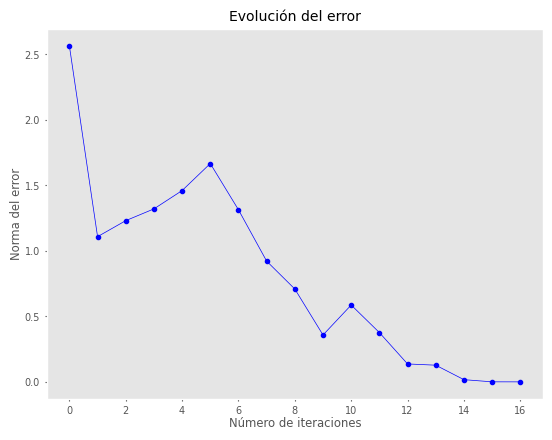

In [11]:
plt.plot(e,'b')
plt.plot(e,'b.')
plt.title("Evolución del error"); plt.grid()
plt.xlabel("Número de iteraciones"); plt.ylabel("Norma del error");

### Comprobacion

In [12]:
S= UR10.fkine([0, 0, 0, 0, 0, 0])
S

   1         0         0        -1.184     
   0         0        -1        -0.2561    
   0         1         0         0.0116    
   0         0         0         1         


In [13]:
T = UR10.fkine([3.3536, -5.8836 , -19.9745, -6.3153, -8.9883,0])
T

   0.7327   -0.6717   -0.1096    1.003     
  -0.2747   -0.1446   -0.9506    0.2981    
   0.6227    0.7266   -0.2905    0.158     
   0         0         0         1         


## URDF

In [14]:
R_UR10=rtb.models.URDF.UR10()
R_UR10

ERobot: UR10 (by Universal Robotics), 6 joints (RRRRRR), 3 branches, dynamics, geometry, collision
┌─────┬────────────────┬───────┬────────────────┬──────────────────────────────────────────┐
│link │      link      │ joint │     parent     │           ETS: parent to link            │
├─────┼────────────────┼───────┼────────────────┼──────────────────────────────────────────┤
│   0 │ world          │       │ BASE           │                                          │
│   1 │ base_link      │       │ world          │ SE3()                                    │
│   2 │ shoulder_link  │     0 │ base_link      │ SE3(0, 0, 0.1273) ⊕ Rz(q0)               │
│   3 │ upper_arm_link │     1 │ shoulder_link  │ SE3(0, 0.2209, 0; 0°, 90°, -0°) ⊕ Ry(q1) │
│   4 │ forearm_link   │     2 │ upper_arm_link │ SE3(0, -0.1719, 0.612) ⊕ Ry(q2)          │
│   5 │ wrist_1_link   │     3 │ forearm_link   │ SE3(0, 0, 0.5723; 0°, 90°, -0°) ⊕ Ry(q3) │
│   6 │ wrist_2_link   │     4 │ wrist_1_link   │ SE3(0, 0.1149,

In [15]:
T=R_UR10.fkine(R_UR10.qz, end="tool0")
T

  -1         0         0         1.184     
   0         0         1         0.2561    
   0         1         0         0.0116    
   0         0         0         1         


In [16]:
R_UR10.plot(R_UR10.qz,backend="swift")

Swift backend, t = 0.05, scene:
  UR10